### PowerFlow with GNN 
Simple network with 9 buses and PyPSA as comparison.

In [19]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
# In the official version generators are connected to bus 1, 2 and 3. 
# This is used as default, but can be changed by specifying bus numbers for each gen.

def create_9_bus_network(gen_bus1=1, gen_bus2=2, gen_bus3=3,steps=5,p_set_gen2=163,p_set_gen3=85,plot=False):
    network = pypsa.Network()
    # Define five snapshots
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    network.set_snapshots(snapshots)
    
    # Set base MVA
    network.sbase = 100.0
    
    # IEEE 9-bus layout coordinates
    bus_coordinates = {
        1: (0, 0),      # Generator 1 (slack)
        2: (4, 6),      # Generator 2
        3: (-4, 6),      # Generator 3
        4: (0, 2),     # Load bus
        5: (-2, 4),     # Load bus
        6: (-2, 6),    # Load bus
        7: (0, 6),      # Load bus
        8: (2, 6),      # Load bus
        9: (2, 4)      # Load bus
    }
    
    # Add buses with official IEEE data   
    for i in range(1, 10):
        bus_data = {
            "x": bus_coordinates[i][0],
            "y": bus_coordinates[i][1],
            "v_nom": 24, #if i in [1,2,3] else 24,
            "v_mag_pu_set": 1.04 if i == gen_bus1 else 1.025 if i in [gen_bus2,gen_bus3] else 1.0,
            "v_mag_pu_min": 0.9,
            "v_mag_pu_max": 1.1,
            "type": "Slack" if i == gen_bus1 else "PV" if i in [gen_bus2,gen_bus3] else "PQ"
            }
        network.add("Bus", f"Bus {i}", **bus_data)
        
        # Add loads with oscillating patterns
        if i in [5, 7, 9]:
            # Create base loads to generate varying load patterns
            base_p = {5: 90, 7: 100, 9: 125}[i]
            base_q = {5: 30, 7: 35, 9: 50}[i]
            variation = 0.3  # 10% variation
            #oscilation pattern based
            # on node number
            base_patterns = {5:np.array([1,0,1,0,-1]),
                        7:np.array([0,1,1,-1,-1]),
                        9: np.array([0,0,1,1,-1])}
            patterns_df = pd.DataFrame({bus: create_pattern(pattern, len(snapshots)) 
                                        for bus, pattern in base_patterns.items()},
                                       index=snapshots
                                       )
            # load is set as base plus/minus a variation of 
            load_p_set = base_p * (1 + variation * patterns_df[i])  # Oscillating pattern
            load_q_set = base_q * (1 + variation * patterns_df[i])  # Oscillating pattern
            
            network.add("Load", f"Load {i}", 
                bus=f"Bus {i}",
                p_set=pd.Series(load_p_set, index=snapshots),
                q_set=pd.Series(load_q_set, index=snapshots))
    
    ## Add Generators with official IEEE data
    gen_data = [
    {"bus": f"Bus {gen_bus1}","control":"Slack",
     "p_nom": 512*0.9,
     "p_min_pu": 10/(512*0.9),
     "p_set": pd.Series([0]*steps,index=snapshots),
     #"q_min_pu":-0.5,
     #"q_max_pu":0.5
     },
    {"bus": f"Bus {gen_bus2}", "control":"PV",
     "p_nom": 270*0.85, 
     "p_min_pu": 10/(270*0.85),
     "p_set": pd.Series([p_set_gen2]*steps, index=snapshots),
     #"q_min_pu":-0.5,
     #"q_max_pu":0.5
     },
    {"bus": f"Bus {gen_bus3}", "control":"PV",
     "p_nom": 125*0.85, 
     "p_min_pu": 10/(125*0.85), 
     "p_set": pd.Series([p_set_gen3]*steps, index=snapshots),
     #"q_min_pu":-0.5,
     #"q_max_pu":0.5
     }
    ]
    
    for i, gen in enumerate(gen_data):
        network.add("Generator", f"Gen {i+1}", **gen)
    
    ## Add Lines and Transformers with official IEEE data (https://ijiset.com/vol2/v2s4/IJISET_V2_I4_68.pdf) Note, bus numbers are not the same as in source
    branch_data = [
        # [from_bus, to_bus, r, x, b, s_nom, tap_ratio] r and x are in pu units
        [1, 4, 0.0000, 0.0576, 0.0000, 150, 1.0],#24/24],  # Transformer 1 (345/230 kV)
        [4, 5, 0.0100, 0.0920, 0.1580, 100, 1.0],      # Line
        [5, 6, 0.0390, 0.1700, 0.3580, 75, 1.0],      # Line
        [3, 6, 0.0000, 0.0586, 0.0000, 150, 1.0],#18/24],  # Transformer 2 (345/230 kV)
        [6, 7, 0.0119, 0.1008, 0.2090, 100, 1.0],      # Line
        [7, 8, 0.0085, 0.0720, 0.1490, 100, 1.0],      # Line
        [8, 2, 0.0000, 0.0625, 0.0000, 175, 1.0],#15,5/24],  # Transformer 3 (345/230 kV)
        [9, 8, 0.0320, 0.1610, 0.3060, 100, 1.0],      # Line
        [9, 4, 0.0100, 0.0850, 0.1760, 100, 1.0]       # Line
        ]
    
    """
    # original branch data for reference
    # [from_bus, to_bus, r, x, b, s_nom, tap_ratio] r and x are in pu units
    [1, 4, 0.0000, 0.0576, 0.0000, 250, 1.0],#24/24], # Transformer 1 (345/230 kV)
    [4, 5, 0.0100, 0.0920, 0.1580, 250, 1.0], # Line
    [5, 6, 0.0390, 0.1700, 0.3580, 150, 1.0], # Line
    [3, 6, 0.0000, 0.0586, 0.0000, 300, 1.0],#18/24], # Transformer 2 (345/230 kV)
    [6, 7, 0.0119, 0.1008, 0.2090, 150, 1.0], # Line
    [7, 8, 0.0085, 0.0720, 0.1490, 250, 1.0], # Line
    [8, 2, 0.0000, 0.0625, 0.0000, 250, 1.0],#15,5/24], # Transformer 3 (345/230 kV)
    [9, 8, 0.0320, 0.1610, 0.3060, 250, 1.0], # Line
    [9, 4, 0.0100, 0.0850, 0.1760, 250, 1.0] # Line
    
    """
    
    for i, branch in enumerate(branch_data):
        f_bus, t_bus, r, x, b, rate, tap = branch
        if tap != 1.0:  # Tap not equal to 1 indicates a transformer
            network.add("Transformer", f"Transformer {i+1}",
                    bus0=f"Bus {f_bus}",
                    bus1=f"Bus {t_bus}",
                    r=r,
                    x=x,
                    b=b/2,
                    s_nom=rate,
                    tap_ratio=tap)
        else:  # Tap equal to 1 indicates normal line (no transformer)
            network.add("Line", f"Line {i+1}",
                    bus0=f"Bus {f_bus}",
                    bus1=f"Bus {t_bus}",
                    r=r,
                    x=x,
                    b=b/2,
                    s_nom=rate
                    )
    
    if plot:
        plot_network(network)
    return network

#Helper function for load pattern:
def create_pattern(base_pattern, num_steps):
    """
    Creates a pattern using numpy's repeat function
    Base pattern with 5 , modified to handle snapshots < 5 and snapshots > 5
    """
    pattern_length = len(base_pattern)
    repeats = np.ceil(num_steps / pattern_length).astype(int)
    extended_pattern = np.repeat(base_pattern, repeats)
    return extended_pattern[:num_steps]


In [21]:
#to plot the network this is called within the create_9_bus_network if plot=True
#using first snapshot values 
def plot_network(n):
    plt.figure(figsize=(12, 8))
    title="IEEE \n9-bus \nSystem"
    plt.title(title,loc='left')
    # Plot base network
    n.plot(
        bus_sizes=0.01,          
        line_widths=2,          
        bus_colors='red',       
        line_colors='blue',     
        margin=0.15,            
        geomap=False           
    )

    # Add bus labels with nominal voltage
    for bus in n.buses.index:
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        v_nom = n.buses.v_nom[bus]
        bus_type = n.buses.type[bus]
        plt.annotate(
            f"Bus {bus}\n{v_nom}kV\n{bus_type}",
            xy=(x, y),
            xytext=(10, 10),
            textcoords='offset points',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )

    # Add generator labels with setpoints
    for gen in n.generators.index:
        bus = n.generators.bus[gen]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        # Access first snapshot of p_set time series
        p_set = n.generators_t.p_set[gen].iloc[0]
        p_nom = n.generators.p_nom[gen]
        plt.annotate(
            f"Gen {gen}\nP={p_set:.1f}MW\nPmax={p_nom:.1f}MW",
            xy=(x, y),
            xytext=(-75, -40),
            textcoords='offset points',
            color='magenta',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )

    # Add load labels with setpoints
    for load in n.loads.index:
        bus = n.loads.bus[load]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        p = n.loads_t.p_set.loc[n.snapshots[0],load]
        q = n.loads_t.q_set.loc[n.snapshots[0],load]
        plt.annotate(
            f"Load {load}\nP={p:.1f}MW\nQ={q:.1f}MVAr",
            xy=(x, y),
            xytext=(-60, 0),
            textcoords='offset points',
            color='brown',
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=8
        )
    #add S_nom labels for branches
    for branch_type in ['Line','Transformer']:
        for branch in getattr(n,branch_type.lower()+'s').index:
            bus0=getattr(n,branch_type.lower()+'s').bus0[branch]
            bus1=getattr(n,branch_type.lower()+'s').bus1[branch]
            s_nom = getattr(n, branch_type.lower() + 's').s_nom[branch]
            r=getattr(n,branch_type.lower()+'s').r[branch]
            x_val=getattr(n,branch_type.lower()+'s').x[branch]
            x0, y0 = n.buses.x[bus0], n.buses.y[bus0]
            x1, y1 = n.buses.x[bus1], n.buses.y[bus1]
            mid_x, mid_y = ((x0 + x1) / 2)-0.25, ((y0 + y1)/2)-0.5
            plt.annotate(
                f"{s_nom:.1f}MVA \n r={r:.4f}\nx={x_val:.4f}",
                xy=(mid_x, mid_y),
                xytext=(0, 10),
                textcoords='offset points',
                color='green',
                bbox=dict(facecolor='white', alpha=0.7),
                fontsize=8,
                ha='center'
            )

    plt.grid(True)
    plt.axis('equal')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='red', label='Buses', 
               markersize=8, linestyle='None'),
        Line2D([0], [0], color='blue', label='Lines/Transformers', 
               linewidth=2),
        Line2D([0], [0], marker='s', color='magenta', label='Generators',
               markersize=8, linestyle='None'),
        Line2D([0], [0], marker='s', color='brown', label='Loads',
               markersize=8, linestyle='None')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    plt.show()

In [22]:

def model_results(n, print_results=False, plot_results=False):
    #n.lpf()
    n.pf(use_seed=True)
    # Create DataFrame with bus results for all snapshots
    bus_results = pd.DataFrame(
        index=n.snapshots,
        columns=pd.MultiIndex.from_product([
            n.buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )

    # Fill results for each snapshot
    for t in n.snapshots:
        for bus in n.buses.index:
            bus_results.loc[t, (bus, 'P (MW)')] = n.buses_t.p.loc[t, bus]
            bus_results.loc[t, (bus, 'Q (MVAr)')] = n.buses_t.q.loc[t, bus]
            bus_results.loc[t, (bus, 'V (pu)')] = n.buses_t.v_mag_pu.loc[t, bus]
            bus_results.loc[t, (bus, 'Angle (deg)')] = n.buses_t.v_ang.loc[t, bus]
    # Create DataFrame for line results
    line_results = pd.DataFrame(
        index=n.snapshots,
        columns=pd.MultiIndex.from_product([
            n.lines.index,
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)']
        ])
    )

    # Fill line results
    for t in n.snapshots:
        for line in n.lines.index:
            line_results.loc[t, (line, 'P0 (MW)')] = n.lines_t.p0.loc[t, line]
            line_results.loc[t, (line, 'P1 (MW)')] = n.lines_t.p1.loc[t, line]
            line_results.loc[t, (line, 'Q0 (MVAr)')] = n.lines_t.q0.loc[t, line]
            line_results.loc[t, (line, 'Q1 (MVAr)')] = n.lines_t.q1.loc[t, line]
    
    if print_results:
        print("\nBus Results:") 
        print(bus_results)
        print("\nLine Results:")
        print(line_results)
        #for s in results_df.index:
        #    print(results_df.loc[s])
    if plot_results:
        plot_network_results(n, bus_results)
        plot_line_results(n, line_results)

    return bus_results, line_results

def plot_network_results(network, results_df):
    """
    Plot network results in 4 subplots: P, Q, V_mag, and V_ang with bus types in legend
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # Get data for each bus
    for bus in network.buses.index:
        # Determine bus type for legend
        if bus in network.loads.bus.values:
            bus_type = f"{bus} (Load)"
        elif bus in network.generators.bus.values:
            gen_idx = network.generators[network.generators.bus == bus].index[0]
            if network.generators.loc[gen_idx, 'control'] == 'Slack':
                bus_type = f"{bus} (Gen-Slack)"
            else:
                bus_type = f"{bus} (Gen-PV)"
        else:
            bus_type = bus
            
        # Active Power (P)
        ax1.plot(results_df.index, results_df[bus]['P (MW)'], marker='o', label=bus_type)
        ax1.set_ylabel('P (MW)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # Reactive Power (Q)
        ax2.plot(results_df.index, results_df[bus]['Q (MVAr)'], marker='o', label=bus_type)
        ax2.set_ylabel('Q (MVAr)')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        # Voltage Magnitude
        ax3.plot(results_df.index, results_df[bus]['V (pu)'], marker='o', label=bus_type)
        ax3.set_ylabel('Voltage (p.u.)')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True)
        
        # Voltage Angle
        ax4.plot(results_df.index, results_df[bus]['Angle (deg)'], marker='o', label=bus_type)
        ax4.set_ylabel('Angle (degrees)')
        ax4.set_xlabel('Time')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True)

    plt.tight_layout()
    plt.show()

def plot_line_results(network, results_df):
    """
    Plot line flow results with one subplot per line, showing P0/P1 and Q0/Q1
    """
    n_lines = len(network.lines)
    fig, axs = plt.subplots(n_lines, 2, figsize=(12, 2*n_lines), sharex=True)
    
    # Get data for each line
    for i, line in enumerate(network.lines.index):
        # Get from/to bus names for title
        from_bus = network.lines.loc[line, 'bus0']
        to_bus = network.lines.loc[line, 'bus1']
        line_name = f"{line} ({from_bus}->{to_bus})"
        
        # Get S_nom for reference line
        s_nom = network.lines.loc[line, 's_nom']
        
        # Active Power (P) - Left subplot
        axs[i, 0].plot(results_df.index, results_df[line]['P0 (MW)'], marker='o', 
                label=f"P-in (from {from_bus})")
        axs[i, 0].plot(results_df.index, -results_df[line]['P1 (MW)'], marker='s', 
                label=f"P-out (to {to_bus})")
        # Add S_nom reference lines
        axs[i, 0].axhline(y=s_nom, color='r', linestyle='--', 
                          label=f"S_nom = {s_nom} MVA")
        axs[i, 0].axhline(y=-s_nom, color='r', linestyle='--', 
                          label=f"S_nom = {-s_nom} MVA")
        axs[i, 0].set_ylabel('P (MW)')
        axs[i, 0].set_title(f"Active Power Flow - {line_name}")
        axs[i, 0].legend()
        axs[i, 0].grid(True)
        
        # Reactive Power (Q) - Right subplot
        axs[i, 1].plot(results_df.index, results_df[line]['Q0 (MVAr)'], marker='o', 
                label=f"Q-in (from {from_bus})")
        axs[i, 1].plot(results_df.index, -results_df[line]['Q1 (MVAr)'], marker='s', 
                label=f"Q-out(to {to_bus})")
        axs[i, 1].set_ylabel('Q (MVAr)')
        axs[i, 1].set_title(f"Reactive Power Flow - {line_name}")
        axs[i, 1].legend()
        axs[i, 1].grid(True)
        
    # Add common x-axis label
    fig.text(0.5, 0.04, 'Time', ha='center')
    
    plt.tight_layout()
    plt.show()

In [25]:

def model_results(n, print_results=False, plot_results=False):
    #n.lpf()
    n.pf(use_seed=True)
    # Create DataFrame with bus results for all snapshots
    bus_results = pd.DataFrame(
        index=n.snapshots,
        columns=pd.MultiIndex.from_product([
            n.buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )

    # Fill results for each snapshot
    for t in n.snapshots:
        for bus in n.buses.index:
            bus_results.loc[t, (bus, 'P (MW)')] = n.buses_t.p.loc[t, bus]
            bus_results.loc[t, (bus, 'Q (MVAr)')] = n.buses_t.q.loc[t, bus]
            bus_results.loc[t, (bus, 'V (pu)')] = n.buses_t.v_mag_pu.loc[t, bus]
            bus_results.loc[t, (bus, 'Angle (deg)')] = n.buses_t.v_ang.loc[t, bus]
    # Create DataFrame for line results
    line_results = pd.DataFrame(
        index=n.snapshots,
        columns=pd.MultiIndex.from_product([
            n.lines.index,
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)']
        ])
    )

    # Fill line results
    for t in n.snapshots:
        for line in n.lines.index:
            line_results.loc[t, (line, 'P0 (MW)')] = n.lines_t.p0.loc[t, line]
            line_results.loc[t, (line, 'P1 (MW)')] = n.lines_t.p1.loc[t, line]
            line_results.loc[t, (line, 'Q0 (MVAr)')] = n.lines_t.q0.loc[t, line]
            line_results.loc[t, (line, 'Q1 (MVAr)')] = n.lines_t.q1.loc[t, line]
    
    if print_results:
        print("\nBus Results:") 
        print(bus_results)
        print("\nLine Results:")
        print(line_results)
        #for s in results_df.index:
        #    print(results_df.loc[s])
    if plot_results:
        plot_network_results(n, bus_results)
        plot_line_results(n, line_results)

    return bus_results, line_results

def plot_network_results(network, results_df):
    """
    Plot network results in 4 subplots: P, Q, V_mag, and V_ang with bus types in legend
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # Get data for each bus
    for bus in network.buses.index:
        # Determine bus type for legend
        if bus in network.loads.bus.values:
            bus_type = f"{bus} (Load)"
        elif bus in network.generators.bus.values:
            gen_idx = network.generators[network.generators.bus == bus].index[0]
            if network.generators.loc[gen_idx, 'control'] == 'Slack':
                bus_type = f"{bus} (Gen-Slack)"
            else:
                bus_type = f"{bus} (Gen-PV)"
        else:
            bus_type = bus
            
        # Active Power (P)
        ax1.plot(results_df.index, results_df[bus]['P (MW)'], marker='o', label=bus_type)
        ax1.set_ylabel('P (MW)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # Reactive Power (Q)
        ax2.plot(results_df.index, results_df[bus]['Q (MVAr)'], marker='o', label=bus_type)
        ax2.set_ylabel('Q (MVAr)')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        # Voltage Magnitude
        ax3.plot(results_df.index, results_df[bus]['V (pu)'], marker='o', label=bus_type)
        ax3.set_ylabel('Voltage (p.u.)')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True)
        
        # Voltage Angle
        ax4.plot(results_df.index, results_df[bus]['Angle (deg)'], marker='o', label=bus_type)
        ax4.set_ylabel('Angle (degrees)')
        ax4.set_xlabel('Time')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True)

    plt.tight_layout()
    plt.show()

def plot_line_results(network, results_df):
    """
    Plot line flow results with one subplot per line, showing P0/P1 and Q0/Q1
    """
    n_lines = len(network.lines)
    fig, axs = plt.subplots(n_lines, 2, figsize=(12, 2*n_lines), sharex=True)
    
    # Get data for each line
    for i, line in enumerate(network.lines.index):
        # Get from/to bus names for title
        from_bus = network.lines.loc[line, 'bus0']
        to_bus = network.lines.loc[line, 'bus1']
        line_name = f"{line} ({from_bus}->{to_bus})"
        
        # Get S_nom for reference line
        s_nom = network.lines.loc[line, 's_nom']
        
        # Active Power (P) - Left subplot
        axs[i, 0].plot(results_df.index, results_df[line]['P0 (MW)'], marker='o', 
                label=f"P-in (from {from_bus})")
        axs[i, 0].plot(results_df.index, -results_df[line]['P1 (MW)'], marker='s', 
                label=f"P-out (to {to_bus})")
        # Add S_nom reference lines
        axs[i, 0].axhline(y=s_nom, color='r', linestyle='--', 
                          label=f"S_nom = {s_nom} MVA")
        axs[i, 0].axhline(y=-s_nom, color='r', linestyle='--', 
                          label=f"S_nom = {-s_nom} MVA")
        axs[i, 0].set_ylabel('P (MW)')
        axs[i, 0].set_title(f"Active Power Flow - {line_name}")
        axs[i, 0].legend()
        axs[i, 0].grid(True)
        
        # Reactive Power (Q) - Right subplot
        axs[i, 1].plot(results_df.index, results_df[line]['Q0 (MVAr)'], marker='o', 
                label=f"Q-in (from {from_bus})")
        axs[i, 1].plot(results_df.index, -results_df[line]['Q1 (MVAr)'], marker='s', 
                label=f"Q-out(to {to_bus})")
        axs[i, 1].set_ylabel('Q (MVAr)')
        axs[i, 1].set_title(f"Reactive Power Flow - {line_name}")
        axs[i, 1].legend()
        axs[i, 1].grid(True)
        
    # Add common x-axis label
    fig.text(0.5, 0.04, 'Time', ha='center')
    
    plt.tight_layout()
    plt.show()

In [ ]:
n = create_9_bus_network(steps=15,p_set_gen2=170,p_set_gen3=100,plot=True) # create the network with input parameters

In [ ]:
bus_results,line_results=model_results(n,print_results=False, plot_results=True) # run the power flow and store results in dfs. Print if print_results = True, plot results if Plot=True

In [ ]:

import torch
from torch_geometric.data import Data, Dataset
import numpy as np
import pandas as pd
import pypsa

class PowerFlowDataset(Dataset):
    def __init__(self, networks, transform=None):
        """
        Dataset for power flow prediction using PyTorch Geometric
        
        Args:
            networks: List of PyPSA network objects with solved power flow
        """
        super().__init__(transform=transform)
        self.networks = networks
        self.process_networks()
        
    def process_networks(self):
        """Pre-process networks to extract features and targets"""
        self.processed_data = []
        
        for network in self.networks:
            # Extract snapshot data
            for t in network.snapshots:
                # Create graph data for this snapshot
                graph_data = self._create_graph_data(network, t)
                self.processed_data.append(graph_data)
                
    def _create_graph_data(self, network, snapshot):
        """Convert PyPSA network at a snapshot to PyG Data object"""
        num_buses = len(network.buses)
        
        # Node features: [bus_type, p, q, v_mag, v_ang]
        
        bus_types = np.zeros((num_buses, 3))
        
        # Extract bus data for this snapshot
        p = network.buses_t.p.loc[snapshot].values
        q = network.buses_t.q.loc[snapshot].values
        v_mag = network.buses_t.v_mag_pu.loc[snapshot].values
        v_ang = network.buses_t.v_ang.loc[snapshot].values
        
        # One-hot encode bus types: [is_slack, is_pv, is_pq]
        for i, bus in enumerate(network.buses.index):
            bus_type = network.buses.loc[bus, 'type']
            if bus_type == 'Slack':
                bus_types[i, 0] = 1  # Slack
            elif bus_type == 'PV':
                bus_types[i, 1] = 1  # PV
            else:
                bus_types[i, 2] = 1  # PQ
        
        # Combine features into a node feature tensor
        # Note: bus_types is already a one-hot encoded matrix
        node_features = np.column_stack([bus_types, p, q, v_mag, v_ang])
        
        # Creating the edge indices and attributes
        edge_index = []
        edge_attr = []
        
        # Process lines
        for line_idx, line in network.lines.iterrows():
            # Get bus indices
            from_bus = int(line['bus0'].split()[-1]) - 1  # Convert 'Bus X' to index X-1
            to_bus = int(line['bus1'].split()[-1]) - 1
            
            # Add edges in both directions (undirected graph)
            edge_index.append([from_bus, to_bus])
            edge_index.append([to_bus, from_bus])
            
            # Edge features: [r, x, b, s_nom]
            edge_features = [line['r'], line['x'], line['b'], line['s_nom']]
            edge_attr.append(edge_features)
            edge_attr.append(edge_features)  # Same features for reverse direction
        
        # Process transformers if any
        for trafo_idx, trafo in network.transformers.iterrows():
            from_bus = int(trafo['bus0'].split()[-1]) - 1
            to_bus = int(trafo['bus1'].split()[-1]) - 1
            
            edge_index.append([from_bus, to_bus])
            edge_index.append([to_bus, from_bus])
            
            # Edge features: [r, x, b, s_nom, tap_ratio]
            edge_features = [trafo['r'], trafo['x'], trafo['b'], trafo['s_nom'], trafo['tap_ratio']]
            # We need to truncate the transformer features to the same number of features as lines   
            # This is a workaround to ensure that the transformer features match the line features
            if len(edge_features) > 4:
                edge_features = edge_features[:4]  # Truncate to match line features
            edge_attr.append(edge_features)
            edge_attr.append(edge_features)
        
        # Target values: what we want to predict
        # For PQ buses: predict v_mag, v_ang
        # For PV buses: predict v_ang, q
        # For Slack bus: predict p, q
        target = np.zeros((num_buses, 4))  # [v_mag, v_ang, p, q]
        
        for i, bus in enumerate(network.buses.index):
            bus_type = network.buses.loc[bus, 'type']
            
            if bus_type == 'PQ':
                # For PQ buses, predict voltage magnitude and angle
                target[i, 0] = v_mag[i]  # v_mag
                target[i, 1] = v_ang[i]  # v_ang
            elif bus_type == 'PV':
                # For PV buses, predict angle and reactive power
                target[i, 1] = v_ang[i]  # v_ang
                target[i, 2] = q[i]      # q
            else:  # Slack
                # For slack bus, predict active and reactive power
                target[i, 2] = p[i]      # p
                target[i, 3] = q[i]      # q
        
        # Convert to PyTorch tensors to create Data object
        # Note: PyTorch Geometric expects edge_index to be in COO format (2D tensor)
        # Convert edge_index to a 2D tensor
        x = torch.tensor(node_features, dtype=torch.float)
        # Contigous is used to ensure that the tensor is stored in contiguous memory for faster access
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() # Transpose to COO format which means basically a 2D tensor
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        y = torch.tensor(target, dtype=torch.float)
        
        # Create masks for different bus types, masks are used to filter out the bus types
        slack_mask = torch.tensor(bus_types[:, 0].astype(bool))
        pv_mask = torch.tensor(bus_types[:, 1].astype(bool))
        pq_mask = torch.tensor(bus_types[:, 2].astype(bool))
        
        return Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y,
            slack_mask=slack_mask,
            pv_mask=pv_mask,
            pq_mask=pq_mask
        )
    
    def len(self):
        return len(self.processed_data)
    
    def get(self, idx):
        return self.processed_data[idx]


In [ ]:
# THe model is a simple GNN with 3 layers and 4 heads, using GATv2Conv for graph convolution
# and GCNConv for the final output layer. The model predicts voltage magnitude, angle, active power, and reactive power.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv

class PowerFlowGNN(nn.Module):
    def __init__(self, node_features=8, edge_features=4, hidden_dim=64, num_layers=3):
        #Node features  [is_slack, is_pv, is_pq, p, q, v_mag, v_ang] which is only 7, but 8 is used as default for simplicity 
        # edge features [r, x, b, s_nom] which is 4 (here we are not using tap_ratio)
        # hidden_dim is the dimension of the hidden layers set to 64 which means 64 neurons in each layer
        super().__init__()
        
        # Initial node embedding
        self.node_embedding = nn.Linear(node_features, hidden_dim) # here node_features are embedded to hidden_dim to get the initial node features
        
        # Graph convolution layers
        self.convs = nn.ModuleList() # module list is used to store the layers
        for _ in range(num_layers):    #  looping through the number of layers to create the layers and append them to the list
            self.convs.append(GATv2Conv(
                in_channels=hidden_dim, # input channels are hidden_dim because the output of the previous layer is the input to the next layer
                out_channels=hidden_dim, # output channels are also hidden_dim to maintain the same dimensionality across layers
                edge_dim=edge_features, # edge features are used to create the edge features for the graph convolution
                heads=4,    # create 4 different attention heads for the graph convolution, one for each layer. The purpose of the attention heads is to create different attention weights for the edges in the graph. this enables the model to capture different relationships between the nodes in the graph.
                concat=False # this is set to false to concatenate the output of the attention heads, which means that the output of the attention heads is averaged instead of concatenated
            ))
        
        # Output layers for different predictions which one prediction head for each of the properties we want to predict
        self.v_mag_pred = nn.Linear(hidden_dim, 1)  # Voltage magnitude
        self.v_ang_pred = nn.Linear(hidden_dim, 1)  # Voltage angle
        self.p_pred = nn.Linear(hidden_dim, 1)      # Active power
        self.q_pred = nn.Linear(hidden_dim, 1)      # Reactive power
        
    def forward(self, data): # Forward pass for the model where the features are embedded first, then processed through the graph convolution layers, and finally the predictions are made
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Initial embedding
        x = self.node_embedding(x) # the node features are embedded to hidden_dim
        x = F.leaky_relu(x) # the activation function used is leaky relu which is a variant of relu that allows a small gradient when the input is negative. 
        
        # Graph convolution layers 
        # The basic idea of convolution is to apply a filter to the input data to extract features. 
        # The filter is applied to the input data in a sliding window fashion, which means that the filter is applied to a small portion of the input data at a time. 
        # This is done by moving the filter across the input data in small steps, which is called the stride. 
        #We then end up with a new set of features that are the result of applying the filter to the input data. 
        # The output of the convolution is then passed through an activation function, which introduces non-linearity into the model. 
        # This is done to allow the model to learn complex relationships between the input data and the output data.
        for conv in self.convs: # conv is the module list that contains the graph convolution layers (as declared at the start of the class)
            x = conv(x, edge_index, edge_attr) # the graph convolution layer is applied to the input data. We use GATv2Conv which applies the graph convolution to the input data and returns the output data.
            x = F.leaky_relu(x) # # The output of the graph convolution layer is then passed through an activation function. F is the functional module in pytorch that contains the activation functions.
        
        # Predictions are made using the output of the last graph convolution layer
        v_mag = self.v_mag_pred(x).squeeze(-1) #squeeze is used to remove the last dimension of the tensor which is 1 in this case. This is done to make the output tensor of shape (batch_size, num_nodes) instead of (batch_size, num_nodes, 1)
        v_ang = self.v_ang_pred(x).squeeze(-1)
        p = self.p_pred(x).squeeze(-1)
        q = self.q_pred(x).squeeze(-1)
        
        # Apply physics constraints based on bus type
        # For PQ buses: predict v_mag, v_ang
        # For PV buses: use known v_mag, predict v_ang, q
        # For Slack bus: use known v_mag, v_ang, predict p, q
        
        # Create output tensor
        output = torch.zeros_like(data.y)
        
        # Fill in predictions based on bus type
        # PQ buses: predict v_mag, v_ang
        output[data.pq_mask, 0] = v_mag[data.pq_mask]  # v_mag
        output[data.pq_mask, 1] = v_ang[data.pq_mask]  # v_ang
        
        # PV buses: use known v_mag (from input), predict v_ang, q
        output[data.pv_mask, 1] = v_ang[data.pv_mask]  # v_ang
        output[data.pv_mask, 3] = q[data.pv_mask]      # q
        
        # Slack bus: use known v_mag, v_ang (from input), predict p, q
        output[data.slack_mask, 2] = p[data.slack_mask]  # p
        output[data.slack_mask, 3] = q[data.slack_mask]  # q
        
        return output


In [32]:
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_power_flow_gnn(networks, num_epochs=200, batch_size=32, lr=0.001):
    # Create dataset
    dataset = PowerFlowDataset(networks)
    
    # Split into train/val/test
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model
    model = PowerFlowGNN(
        node_features=dataset[0].x.size(1),
        edge_features=dataset[0].edge_attr.size(1),
        hidden_dim=64,
        num_layers=3
    )
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            
            # Forward pass
            pred = model(batch)
            
            # Compute loss
            loss, _, _ = physics_informed_loss(
                pred, batch.y, batch, networks[0], 0)  # Using first network for Y matrix
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                pred = model(batch)
                loss, _, _ = physics_informed_loss(
                    pred, batch.y, batch, networks[0], 0)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.6f}, "
              f"Val Loss: {val_loss:.6f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Evaluate on test set
    model.eval()
    test_loss = 0
    mse_loss_total = 0
    physics_loss_total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            pred = model(batch)
            loss, mse, physics = physics_informed_loss(
                pred, batch.y, batch, networks[0], 0)
            test_loss += loss.item()
            mse_loss_total += mse.item()
            physics_loss_total += physics.item()
    
    test_loss = test_loss / len(test_loader)
    mse_loss_avg = mse_loss_total / len(test_loader)
    physics_loss_avg = physics_loss_total / len(test_loader)
    
    print(f"Test Loss: {test_loss:.6f}")
    print(f"MSE Loss: {mse_loss_avg:.6f}")
    print(f"Physics Loss: {physics_loss_avg:.6f}")
    
    return model, (train_losses, val_losses)


In [ ]:
def physics_informed_loss(pred, target, data, network, snapshot_idx):
    """
    Physics-informed loss function that combines:
    1. MSE loss between predictions and targets
    2. Power balance constraints from Kirchhoff's laws
    """
    # Data-driven MSE loss
 
    mse_loss = 0.0
    
    # Only compute loss for values we're trying to predict
    # For PQ buses: v_mag, v_ang
    pq_mask = data.pq_mask # t
    if pq_mask.any():
        mse_loss += F.mse_loss(pred[pq_mask, :2], target[pq_mask, :2])
    
    # For PV buses: v_ang, q
    pv_mask = data.pv_mask
    if pv_mask.any():
        mse_loss += F.mse_loss(pred[pv_mask, 1], target[pv_mask, 1])  # v_ang
        mse_loss += F.mse_loss(pred[pv_mask, 3], target[pv_mask, 3])  # q
    
    # For Slack bus: p, q
    slack_mask = data.slack_mask
    if slack_mask.any():
        mse_loss += F.mse_loss(pred[slack_mask, 2:], target[slack_mask, 2:])
    
    # Physics-based power balance constraints
    # Extract predicted values
    v_mag = torch.zeros(pred.size(0)) # creating an initial tensor of zeros with the same size as the prediction tensor
    v_ang = torch.zeros(pred.size(0))
    p = torch.zeros(pred.size(0))
    q = torch.zeros(pred.size(0))
    
    # Based on node_features structure:
    # x = [bus_type_one_hot (3 dims), p, q, v_mag, v_ang]
    # Indices are: p=3, q=4, v_mag=5, v_ang=6
    # for the prediction tenso the incices are  v_mag=0, v_ang=1, p=2, q=3
    
    # Fill in known and predicted values
    # PQ buses
    v_mag[pq_mask] = pred[pq_mask, 0]  # Predicted. the pred[pq_mask,0] will return the predicted voltage magnitude for the PQ buses] 
    v_ang[pq_mask] = pred[pq_mask, 1]  # Predicted
    p[pq_mask] = data.x[pq_mask, 3]    # Known (from input)
    q[pq_mask] = data.x[pq_mask, 4]    # Known (from input)
    
    # PV buses
    v_mag[pv_mask] = data.x[pv_mask, 5]  # Known (from input)
    v_ang[pv_mask] = pred[pv_mask, 1]    # Predicted
    p[pv_mask] = data.x[pv_mask, 3]      # Known (from input)
    q[pv_mask] = pred[pv_mask, 3]        # Predicted
    
    # Slack bus
    v_mag[slack_mask] = data.x[slack_mask, 5]  # Known (from input)
    v_ang[slack_mask] = data.x[slack_mask, 6]  # Known (from input)
    p[slack_mask] = pred[slack_mask, 2]        # Predicted
    q[slack_mask] = pred[slack_mask, 3]        # Predicted
    
    # Calculate power flow using admittance matrix
    # Get admittance matrix from PyPSA
    Y_bus = get_ybus_from_pypsa(network)
    Y_bus_tensor = torch.tensor(Y_bus, dtype=torch.complex64) #here we are converting the Y_bus matrix to a complex tensor
    
    Y_bus = get_ybus_from_pypsa(network)
    Y_bus_tensor = torch.tensor(Y_bus, dtype=torch.complex64)
    
    # Initialize power balance loss
    power_balance_loss = 0.0
    
    # Get batch information
    if hasattr(data, 'batch'):
        # For batched data
        num_graphs = data.batch.max().item() + 1
        num_nodes_per_graph = len(data.x) // num_graphs
        
        # Process each graph in the batch separately
        for graph_idx in range(num_graphs):
            # Create mask for this graph
            graph_mask = (data.batch == graph_idx)
            
            # Extract data for this graph only
            v_mag_graph = torch.zeros(num_nodes_per_graph)
            v_ang_graph = torch.zeros(num_nodes_per_graph)
            p_graph = torch.zeros(num_nodes_per_graph)
            q_graph = torch.zeros(num_nodes_per_graph)
            
            # Get node indices for this graph
            node_indices = torch.where(graph_mask)[0]
            
            # Fill in values for this graph
            for i, node_idx in enumerate(node_indices):
                # Get bus type masks for this node
                is_pq = data.pq_mask[node_idx]
                is_pv = data.pv_mask[node_idx]
                is_slack = data.slack_mask[node_idx]
                
                # Fill based on bus type 
                if is_pq:
                    v_mag_graph[i] = pred[node_idx, 0]
                    v_ang_graph[i] = pred[node_idx, 1]
                    p_graph[i] = data.x[node_idx, 3]
                    q_graph[i] = data.x[node_idx, 4]
                elif is_pv:
                    v_mag_graph[i] = data.x[node_idx, 5]
                    v_ang_graph[i] = pred[node_idx, 1]
                    p_graph[i] = data.x[node_idx, 3]
                    q_graph[i] = pred[node_idx, 3]
                elif is_slack:
                    v_mag_graph[i] = data.x[node_idx, 5]
                    v_ang_graph[i] = data.x[node_idx, 6]
                    p_graph[i] = pred[node_idx, 2]
                    q_graph[i] = pred[node_idx, 3]
            
            # Calculate power flow for this graph
            v_complex_graph = v_mag_graph * torch.exp(1j * torch.deg2rad(v_ang_graph))
            S_calc_graph = v_complex_graph * torch.conj(torch.matmul(Y_bus_tensor, v_complex_graph))
            p_calc_graph = torch.real(S_calc_graph)
            
            q_calc_graph = torch.imag(S_calc_graph)
            
            # Add to power balance loss
            power_balance_loss += F.mse_loss(p_calc_graph, p_graph) + F.mse_loss(q_calc_graph, q_graph)
        
        # Average over all graphs in batch
        power_balance_loss /= num_graphs
    else:
        # Convert voltage to complex form
        v_complex = v_mag * torch.exp(1j * torch.deg2rad(v_ang))
        
        # Calculate power using S = V * (Y*V)* (complex power equation)
        S_calc = v_complex * torch.conj(torch.matmul(Y_bus_tensor, v_complex))
        p_calc = torch.real(S_calc)
        q_calc = torch.imag(S_calc)
        
        # Power balance loss
        power_balance_loss = F.mse_loss(p_calc, p) + F.mse_loss(q_calc, q)
    
    # Total loss (weighted sum)
    total_loss = 0.7 * mse_loss + 0.3 * power_balance_loss
    
    return total_loss, mse_loss, power_balance_loss
 

In [38]:
def get_ybus_from_pypsa(network, snapshot=None):
    """
    Extract the admittance matrix (Y-bus) from a PyPSA network
    
    Args:
        network: PyPSA network object
        snapshot: Optional snapshot to use for time-dependent parameters
    
    Returns:
        Y_bus: Complex numpy array representing the admittance matrix
    """
    import numpy as np
    from scipy.sparse import csr_matrix, lil_matrix
    
    # Get number of buses
    n_buses = len(network.buses)
    
    # Initialize Y-bus matrix as sparse matrix
    Y_bus = lil_matrix((n_buses, n_buses), dtype=complex)
    
    # Process lines
    for line_idx, line in network.lines.iterrows():
        # Get bus indices (convert from 1-indexed to 0-indexed)
        from_bus = int(line['bus0'].split()[-1]) - 1
        to_bus = int(line['bus1'].split()[-1]) - 1
        
        # Get line parameters
        r = line['r']
        x = line['x']
        b = line['b']
        
        # Calculate admittance
        y_series = 1 / complex(r, x)
        y_shunt = complex(0, b/2)
        
        # Add to Y-bus matrix
        # Diagonal elements
        Y_bus[from_bus, from_bus] += y_series + y_shunt
        Y_bus[to_bus, to_bus] += y_series + y_shunt
        
        # Off-diagonal elements
        Y_bus[from_bus, to_bus] -= y_series
        Y_bus[to_bus, from_bus] -= y_series
    
    # Process transformers if any
    for trafo_idx, trafo in network.transformers.iterrows():
        # Get bus indices
        from_bus = int(trafo['bus0'].split()[-1]) - 1
        to_bus = int(trafo['bus1'].split()[-1]) - 1
        
        # Get transformer parameters
        r = trafo['r']
        x = trafo['x']
        tap = trafo.get('tap_ratio', 1.0)
        
        # Calculate admittance
        y_series = 1 / complex(r, x)
        
        # Add to Y-bus matrix with tap ratio consideration
        # Diagonal elements
        Y_bus[from_bus, from_bus] += y_series / (tap**2)
        Y_bus[to_bus, to_bus] += y_series
        
        # Off-diagonal elements
        Y_bus[from_bus, to_bus] -= y_series / tap
        Y_bus[to_bus, from_bus] -= y_series / tap
    
    # Convert to dense numpy array for easier use with PyTorch
    Y_bus = Y_bus.toarray()
    
    return Y_bus


In [35]:
def generate_training_data(base_network, num_scenarios=100, steps_per_scenario=15):
    """
    Generate multiple network scenarios by varying load and generation
    
    Args:
        base_network: Base PyPSA network
        num_scenarios: Number of different scenarios to generate
        steps_per_scenario: Number of snapshots per scenario
    
    Returns:
        List of PyPSA networks with solved power flow
    """
    networks = []
    
    for i in range(num_scenarios):
        # Create a new network with random variations
        p_set_gen2 = np.random.uniform(150, 180)  # Random generation for Gen 2
        p_set_gen3 = np.random.uniform(80, 110)   # Random generation for Gen 3
        
        # Create network with these parameters
        network = create_9_bus_network(
            steps=steps_per_scenario,
            p_set_gen2=p_set_gen2,
            p_set_gen3=p_set_gen3,
            plot=False
        )
        
        # Solve power flow
        network.pf(use_seed=True)
        
        # Add to list
        networks.append(network)
        
        if i % 10 == 0:
            print(f"Generated {i+1}/{num_scenarios} networks")
    
    return networks


In [ ]:
def evaluate_model(model, network, snapshot_idx=0):
    """
    Evaluate model on a specific network and snapshot
    
    Args:
        model: Trained PowerFlowGNN model
        network: PyPSA network to evaluate on
        snapshot_idx: Snapshot index to evaluate
    
    Returns:
        Dictionary of metrics and predictions
    """
    # Create dataset from this network
    dataset = PowerFlowDataset([network])
    
    # Get data for the specific snapshot
    data = dataset[snapshot_idx]
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        pred = model(data)
    
    # Extract true values from network
    true_v_mag = network.buses_t.v_mag_pu.iloc[snapshot_idx].values
    true_v_ang = network.buses_t.v_ang.iloc[snapshot_idx].values
    true_p = network.buses_t.p.iloc[snapshot_idx].values
    true_q = network.buses_t.q.iloc[snapshot_idx].values
    
    # Extract predicted values
    pred_v_mag = torch.zeros_like(torch.tensor(true_v_mag, dtype=torch.float))
    pred_v_ang = torch.zeros_like(torch.tensor(true_v_ang, dtype=torch.float))
    pred_p = torch.zeros_like(torch.tensor(true_p, dtype=torch.float))
    pred_q = torch.zeros_like(torch.tensor(true_q, dtype=torch.float))
    
    # Fill in predictions based on bus type
    for i, bus in enumerate(network.buses.index):
        bus_type = network.buses.loc[bus, 'type']
        
        if bus_type == 'PQ':
            # For PQ buses, predict v_mag, v_ang
            pred_v_mag[i] = pred[i, 0]
            pred_v_ang[i] = pred[i, 1]
            pred_p[i] = true_p[i]  # Known
            pred_q[i] = true_q[i]  # Known
        elif bus_type == 'PV':
            # For PV buses, predict v_ang, q
            pred_v_mag[i] = true_v_mag[i]  # Known
            pred_v_ang[i] = pred[i, 1]
            pred_p[i] = true_p[i]  # Known
            pred_q[i] = pred[i, 3]
        else:  # Slack
            # For slack bus, predict p, q
            pred_v_mag[i] = true_v_mag[i]  # Known
            pred_v_ang[i] = true_v_ang[i]  # Known
            pred_p[i] = pred[i, 2]
            pred_q[i] = pred[i, 3]
    
    # Calculate metrics
    v_mag_mae = torch.mean(torch.abs(pred_v_mag - torch.tensor(true_v_mag, dtype=torch.float)))
    v_ang_rmse = torch.sqrt(torch.mean((pred_v_ang - torch.tensor(true_v_ang, dtype=torch.float))**2))
    p_mae = torch.mean(torch.abs(pred_p - torch.tensor(true_p, dtype=torch.float)))
    q_mae = torch.mean(torch.abs(pred_q - torch.tensor(true_q, dtype=torch.float)))
    
    # Calculate line flows using predicted values
    pred_line_flows = calculate_line_flows(network, pred_v_mag.numpy(), pred_v_ang.numpy(), snapshot_idx)
    true_line_flows = {
        'p0': network.lines_t.p0.iloc[snapshot_idx].values,
        'p1': network.lines_t.p1.iloc[snapshot_idx].values,
        'q0': network.lines_t.q0.iloc[snapshot_idx].values,
        'q1': network.lines_t.q1.iloc[snapshot_idx].values
    }
    
    # Line flow metrics
    p_flow_mae = np.mean(np.abs(pred_line_flows['p0'] - true_line_flows['p0']))
    q_flow_mae = np.mean(np.abs(pred_line_flows['q0'] - true_line_flows['q0']))
    
    # Return metrics and predictions
    return {
        'metrics': {
            'v_mag_mae': v_mag_mae.item(),
            'v_ang_rmse': v_ang_rmse.item(),
            'p_mae': p_mae.item(),
            'q_mae': q_mae.item(),
            'p_flow_mae': p_flow_mae,
            'q_flow_mae': q_flow_mae
        },
        'predictions': {
            'v_mag': pred_v_mag.numpy(),
            'v_ang': pred_v_ang.numpy(),
            'p': pred_p.numpy(),
            'q': pred_q.numpy(),
            'line_flows': pred_line_flows
        },
        'true_values': {
            'v_mag': true_v_mag,
            'v_ang': true_v_ang,
            'p': true_p,
            'q': true_q,
            'line_flows': true_line_flows
        }
    }

def calculate_line_flows(network, v_mag, v_ang, snapshot_idx):
    """
    Calculate line flows from voltage magnitudes and angles
    
    Args:
        network: PyPSA network
        v_mag: Voltage magnitudes (per unit)
        v_ang: Voltage angles (degrees)
        snapshot_idx: Snapshot index
    
    Returns:
        Dictionary with line flows
    """
    # Convert angles to radians
    v_ang_rad = np.deg2rad(v_ang)
    
    # Initialize arrays for line flows
    num_lines = len(network.lines)
    p0 = np.zeros(num_lines)
    p1 = np.zeros(num_lines)
    q0 = np.zeros(num_lines)
    q1 = np.zeros(num_lines)
    
    # Calculate line flows for each line
    for i, (idx, line) in enumerate(network.lines.iterrows()):
        # Get bus indices
        from_bus = int(line['bus0'].split()[-1]) - 1  # Convert 'Bus X' to index X-1
        to_bus = int(line['bus1'].split()[-1]) - 1
        
        # Get line parameters
        r = line['r']
        x = line['x']
        b = line['b']
        
        # Calculate admittance
        y = 1 / complex(r, x)
        g = y.real
        b_line = y.imag
        
        # Get voltage at from and to buses
        v_from = v_mag[from_bus]
        v_to = v_mag[to_bus]
        theta_from = v_ang_rad[from_bus]
        theta_to = v_ang_rad[to_bus]
        
        # Calculate angle difference
        theta_diff = theta_from - theta_to
        
        # Calculate active power flow
        p0[i] = (v_from**2 * g - v_from * v_to * g * np.cos(theta_diff) 
                - v_from * v_to * b_line * np.sin(theta_diff))
        p1[i] = (v_to**2 * g - v_from * v_to * g * np.cos(theta_diff) 
                + v_from * v_to * b_line * np.sin(theta_diff))
        
        # Calculate reactive power flow
        q0[i] = (-v_from**2 * (b_line + b/2) + v_from * v_to * b_line * np.cos(theta_diff) 
                - v_from * v_to * g * np.sin(theta_diff))
        q1[i] = (-v_to**2 * (b_line + b/2) + v_from * v_to * b_line * np.cos(theta_diff) 
                + v_from * v_to * g * np.sin(theta_diff))
    
    # Convert to MW and MVAr (assuming base power of 100 MVA)
    base_mva = network.sbase
    p0 *= base_mva
    p1 *= base_mva
    q0 *= base_mva
    q1 *= base_mva
    
    return {'p0': p0, 'p1': p1, 'q0': q0, 'q1': q1}

def visualize_results(results, network):
    """
    Visualize model predictions vs true values
    
    Args:
        results: Results dictionary from evaluate_model
        network: PyPSA network
    """
    # Extract predictions and true values
    pred_v_mag = results['predictions']['v_mag']
    true_v_mag = results['true_values']['v_mag']
    pred_v_ang = results['predictions']['v_ang']
    true_v_ang = results['true_values']['v_ang']
    pred_p = results['predictions']['p']
    true_p = results['true_values']['p']
    pred_q = results['predictions']['q']
    true_q = results['true_values']['q']
    
    # Create bus labels with types
    bus_labels = []
    for i, bus in enumerate(network.buses.index):
        bus_type = network.buses.loc[bus, 'type']
        bus_labels.append(f"{bus} ({bus_type})")
    
    # Create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot voltage magnitude
    axs[0, 0].bar(np.arange(len(bus_labels)), true_v_mag, width=0.4, label='True', alpha=0.7)
    axs[0, 0].bar(np.arange(len(bus_labels))+0.4, pred_v_mag, width=0.4, label='Predicted', alpha=0.7)
    axs[0, 0].set_xticks(np.arange(len(bus_labels))+0.2)
    axs[0, 0].set_xticklabels(bus_labels, rotation=45, ha='right')
    axs[0, 0].set_ylabel('Voltage Magnitude (p.u.)')
    axs[0, 0].set_title('Voltage Magnitude Comparison')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    
    # Plot voltage angle
    axs[0, 1].bar(np.arange(len(bus_labels)), true_v_ang, width=0.4, label='True', alpha=0.7)
    axs[0, 1].bar(np.arange(len(bus_labels))+0.4, pred_v_ang, width=0.4, label='Predicted', alpha=0.7)
    axs[0, 1].set_xticks(np.arange(len(bus_labels))+0.2)
    axs[0, 1].set_xticklabels(bus_labels, rotation=45, ha='right')
    axs[0, 1].set_ylabel('Voltage Angle (degrees)')
    axs[0, 1].set_title('Voltage Angle Comparison')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
    
    # Plot active power
    axs[1, 0].bar(np.arange(len(bus_labels)), true_p, width=0.4, label='True', alpha=0.7)
    axs[1, 0].bar(np.arange(len(bus_labels))+0.4, pred_p, width=0.4, label='Predicted', alpha=0.7)
    axs[1, 0].set_xticks(np.arange(len(bus_labels))+0.2)
    axs[1, 0].set_xticklabels(bus_labels, rotation=45, ha='right')
    axs[1, 0].set_ylabel('Active Power (MW)')
    axs[1, 0].set_title('Active Power Comparison')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)
    
    # Plot reactive power
    axs[1, 1].bar(np.arange(len(bus_labels)), true_q, width=0.4, label='True', alpha=0.7)
    axs[1, 1].bar(np.arange(len(bus_labels))+0.4, pred_q, width=0.4, label='Predicted', alpha=0.7)
    axs[1, 1].set_xticks(np.arange(len(bus_labels))+0.2)
    axs[1, 1].set_xticklabels(bus_labels, rotation=45, ha='right')
    axs[1, 1].set_ylabel('Reactive Power (MVAr)')
    axs[1, 1].set_title('Reactive Power Comparison')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot line flow comparison
    pred_flows = results['predictions']['line_flows']
    true_flows = results['true_values']['line_flows']
    
    # Create line labels
    line_labels = []
    for i, line in enumerate(network.lines.index):
        from_bus = network.lines.loc[line, 'bus0']
        to_bus = network.lines.loc[line, 'bus1']
        line_labels.append(f"{line}\n({from_bus}->{to_bus})")
    
    # Create figure for line flows
    fig, axs = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot active power flow
    axs[0].bar(np.arange(len(line_labels)), true_flows['p0'], width=0.4, label='True', alpha=0.7)
    axs[0].bar(np.arange(len(line_labels))+0.4, pred_flows['p0'], width=0.4, label='Predicted', alpha=0.7)
    axs[0].set_xticks(np.arange(len(line_labels))+0.2)
    axs[0].set_xticklabels(line_labels, rotation=45, ha='right')
    axs[0].set_ylabel('Active Power Flow (MW)')
    axs[0].set_title('Line Active Power Flow Comparison (From Bus)')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)
    
    # Plot reactive power flow
    axs[1].bar(np.arange(len(line_labels)), true_flows['q0'], width=0.4, label='True', alpha=0.7)
    axs[1].bar(np.arange(len(line_labels))+0.4, pred_flows['q0'], width=0.4, label='Predicted', alpha=0.7)
    axs[1].set_xticks(np.arange(len(line_labels))+0.2)
    axs[1].set_xticklabels(line_labels, rotation=45, ha='right')
    axs[1].set_ylabel('Reactive Power Flow (MVAr)')
    axs[1].set_title('Line Reactive Power Flow Comparison (From Bus)')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
    # Print metrics
    print("Model Performance Metrics:")
    print(f"Voltage Magnitude MAE: {results['metrics']['v_mag_mae']:.6f} p.u.")
    print(f"Voltage Angle RMSE: {results['metrics']['v_ang_rmse']:.6f} degrees")
    print(f"Active Power MAE: {results['metrics']['p_mae']:.6f} MW")
    print(f"Reactive Power MAE: {results['metrics']['q_mae']:.6f} MVAr")
    print(f"Line Active Power Flow MAE: {results['metrics']['p_flow_mae']:.6f} MW")
    print(f"Line Reactive Power Flow MAE: {results['metrics']['q_flow_mae']:.6f} MVAr")

def compare_execution_time(model, network, num_runs=100):
    """
    Compare execution time between GNN and traditional power flow
    
    Args:
        model: Trained PowerFlowGNN model
        network: PyPSA network
        num_runs: Number of runs for timing
    """
    import time
    
    # Time GNN inference
    dataset = PowerFlowDataset([network])
    data = dataset[0]
    
    # Warm-up run
    model.eval()
    with torch.no_grad():
        _ = model(data)
    
    # Time GNN inference
    gnn_times = []
    for _ in range(num_runs):
        start_time = time.time()
        with torch.no_grad():
            _ = model(data)
        gnn_times.append(time.time() - start_time)
    
    # Time traditional power flow
    pf_times = []
    for _ in range(num_runs):
        # Create a copy to avoid modifying the original
        net_copy = network.copy()
        start_time = time.time()
        net_copy.pf(use_seed=True)
        pf_times.append(time.time() - start_time)
    
    # Calculate statistics
    gnn_avg = np.mean(gnn_times) * 1000  # Convert to ms
    gnn_std = np.std(gnn_times) * 1000
    pf_avg = np.mean(pf_times) * 1000
    pf_std = np.std(pf_times) * 1000
    speedup = pf_avg / gnn_avg
    
    # Print results
    print(f"GNN Inference Time: {gnn_avg:.2f} ± {gnn_std:.2f} ms")
    print(f"Traditional PF Time: {pf_avg:.2f} ± {pf_std:.2f} ms")
    print(f"Speedup: {speedup:.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.bar(['GNN', 'Traditional PF'], [gnn_avg, pf_avg], yerr=[gnn_std, pf_std], alpha=0.7)
    plt.ylabel('Execution Time (ms)')
    plt.title('Execution Time Comparison')
    plt.grid(True, alpha=0.3)
    plt.show()


Epoch 1/100: 100%|██████████| 17/17 [00:02<00:00,  7.64it/s]


Epoch 1/100, Train Loss: 6180.152401, Val Loss: 6263.032227, LR: 0.001000


Epoch 2/100: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


Epoch 2/100, Train Loss: 5426.182086, Val Loss: 4731.432251, LR: 0.001000


Epoch 3/100: 100%|██████████| 17/17 [00:02<00:00,  7.96it/s]


Epoch 3/100, Train Loss: 3961.635555, Val Loss: 3611.011597, LR: 0.001000


Epoch 4/100: 100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


Epoch 4/100, Train Loss: 3497.737721, Val Loss: 3426.986267, LR: 0.001000


Epoch 5/100: 100%|██████████| 17/17 [00:02<00:00,  8.18it/s]


Epoch 5/100, Train Loss: 3343.320758, Val Loss: 3252.309875, LR: 0.001000


Epoch 6/100: 100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


Epoch 6/100, Train Loss: 3108.924345, Val Loss: 3021.913879, LR: 0.001000


Epoch 7/100: 100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


Epoch 7/100, Train Loss: 2911.778119, Val Loss: 2905.005188, LR: 0.001000


Epoch 8/100: 100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


Epoch 8/100, Train Loss: 2816.907543, Val Loss: 2843.611694, LR: 0.001000


Epoch 9/100: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


Epoch 9/100, Train Loss: 2785.383200, Val Loss: 2820.715942, LR: 0.001000


Epoch 10/100: 100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


Epoch 10/100, Train Loss: 2774.538660, Val Loss: 2804.978638, LR: 0.001000


Epoch 11/100: 100%|██████████| 17/17 [00:02<00:00,  7.57it/s]


Epoch 11/100, Train Loss: 2756.083238, Val Loss: 2792.107971, LR: 0.001000


Epoch 12/100: 100%|██████████| 17/17 [00:02<00:00,  7.66it/s]


Epoch 12/100, Train Loss: 2748.295999, Val Loss: 2784.144714, LR: 0.001000


Epoch 13/100: 100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


Epoch 13/100, Train Loss: 2760.376680, Val Loss: 2795.923767, LR: 0.001000


Epoch 14/100: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


Epoch 14/100, Train Loss: 2727.571504, Val Loss: 2776.616760, LR: 0.001000


Epoch 15/100: 100%|██████████| 17/17 [00:02<00:00,  7.96it/s]


Epoch 15/100, Train Loss: 2738.463465, Val Loss: 2776.061340, LR: 0.001000


Epoch 16/100: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


Epoch 16/100, Train Loss: 2724.548598, Val Loss: 2768.622986, LR: 0.001000


Epoch 17/100: 100%|██████████| 17/17 [00:02<00:00,  7.53it/s]


Epoch 17/100, Train Loss: 2729.910185, Val Loss: 2761.069519, LR: 0.001000


Epoch 18/100: 100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


Epoch 18/100, Train Loss: 2716.412167, Val Loss: 2759.903259, LR: 0.001000


Epoch 19/100: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


Epoch 19/100, Train Loss: 2702.583453, Val Loss: 2754.866150, LR: 0.001000


Epoch 20/100: 100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


Epoch 20/100, Train Loss: 2708.227108, Val Loss: 2753.081970, LR: 0.001000


Epoch 21/100: 100%|██████████| 17/17 [00:02<00:00,  7.96it/s]


Epoch 21/100, Train Loss: 2706.752930, Val Loss: 2752.093689, LR: 0.001000


Epoch 22/100: 100%|██████████| 17/17 [00:02<00:00,  8.01it/s]


Epoch 22/100, Train Loss: 2734.576387, Val Loss: 2808.731567, LR: 0.001000


Epoch 23/100: 100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


Epoch 23/100, Train Loss: 2754.112175, Val Loss: 2824.940430, LR: 0.001000


Epoch 24/100: 100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


Epoch 24/100, Train Loss: 2747.847829, Val Loss: 2778.648315, LR: 0.001000


Epoch 25/100: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


Epoch 25/100, Train Loss: 2716.061394, Val Loss: 2754.138794, LR: 0.001000


Epoch 26/100: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


Epoch 26/100, Train Loss: 2701.674862, Val Loss: 2750.010803, LR: 0.001000


Epoch 27/100: 100%|██████████| 17/17 [00:02<00:00,  8.38it/s]


Epoch 27/100, Train Loss: 2703.331112, Val Loss: 2748.275452, LR: 0.001000


Epoch 28/100: 100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


Epoch 28/100, Train Loss: 2693.544534, Val Loss: 2747.056885, LR: 0.001000


Epoch 29/100: 100%|██████████| 17/17 [00:02<00:00,  8.06it/s]


Epoch 29/100, Train Loss: 2701.879323, Val Loss: 2745.904602, LR: 0.001000


Epoch 30/100: 100%|██████████| 17/17 [00:02<00:00,  8.10it/s]


Epoch 30/100, Train Loss: 2708.170769, Val Loss: 2744.977356, LR: 0.001000


Epoch 31/100: 100%|██████████| 17/17 [00:02<00:00,  7.72it/s]


Epoch 31/100, Train Loss: 2697.566406, Val Loss: 2744.646057, LR: 0.001000


Epoch 32/100: 100%|██████████| 17/17 [00:02<00:00,  7.78it/s]


Epoch 32/100, Train Loss: 2692.568862, Val Loss: 2743.639404, LR: 0.001000


Epoch 33/100: 100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


Epoch 33/100, Train Loss: 2699.653349, Val Loss: 2743.486450, LR: 0.001000


Epoch 34/100: 100%|██████████| 17/17 [00:02<00:00,  8.03it/s]


Epoch 34/100, Train Loss: 2696.688491, Val Loss: 2742.491028, LR: 0.001000


Epoch 35/100: 100%|██████████| 17/17 [00:02<00:00,  8.25it/s]


Epoch 35/100, Train Loss: 2690.364631, Val Loss: 2742.028442, LR: 0.001000


Epoch 36/100: 100%|██████████| 17/17 [00:02<00:00,  8.25it/s]


Epoch 36/100, Train Loss: 2692.216826, Val Loss: 2741.832458, LR: 0.001000


Epoch 37/100: 100%|██████████| 17/17 [00:02<00:00,  7.68it/s]


Epoch 37/100, Train Loss: 2693.891975, Val Loss: 2740.969116, LR: 0.001000


Epoch 38/100: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


Epoch 38/100, Train Loss: 2693.022863, Val Loss: 2741.352173, LR: 0.001000


Epoch 39/100: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


Epoch 39/100, Train Loss: 2693.174015, Val Loss: 2740.109863, LR: 0.001000


Epoch 40/100: 100%|██████████| 17/17 [00:02<00:00,  7.65it/s]


Epoch 40/100, Train Loss: 2698.134751, Val Loss: 2743.530396, LR: 0.001000


Epoch 41/100: 100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


Epoch 41/100, Train Loss: 2693.639002, Val Loss: 2742.159607, LR: 0.001000


Epoch 42/100: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


Epoch 42/100, Train Loss: 2692.004596, Val Loss: 2739.127563, LR: 0.001000


Epoch 43/100: 100%|██████████| 17/17 [00:02<00:00,  7.59it/s]


Epoch 43/100, Train Loss: 2678.257884, Val Loss: 2738.941895, LR: 0.001000


Epoch 44/100: 100%|██████████| 17/17 [00:02<00:00,  8.12it/s]


Epoch 44/100, Train Loss: 2685.346464, Val Loss: 2738.831787, LR: 0.001000


Epoch 45/100: 100%|██████████| 17/17 [00:02<00:00,  8.19it/s]


Epoch 45/100, Train Loss: 2688.073371, Val Loss: 2738.319031, LR: 0.001000


Epoch 46/100: 100%|██████████| 17/17 [00:02<00:00,  8.12it/s]


Epoch 46/100, Train Loss: 2689.442842, Val Loss: 2738.686096, LR: 0.001000


Epoch 47/100: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


Epoch 47/100, Train Loss: 2692.465246, Val Loss: 2737.919800, LR: 0.001000


Epoch 48/100: 100%|██████████| 17/17 [00:02<00:00,  8.21it/s]


Epoch 48/100, Train Loss: 2705.890927, Val Loss: 2737.910217, LR: 0.001000


Epoch 49/100: 100%|██████████| 17/17 [00:02<00:00,  7.24it/s]


Epoch 49/100, Train Loss: 2702.564482, Val Loss: 2737.954163, LR: 0.001000


Epoch 50/100: 100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Epoch 50/100, Train Loss: 2694.303409, Val Loss: 2737.518005, LR: 0.001000


Epoch 51/100: 100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


Epoch 51/100, Train Loss: 2679.869844, Val Loss: 2737.523071, LR: 0.001000


Epoch 52/100: 100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


Epoch 52/100, Train Loss: 2684.670152, Val Loss: 2737.415649, LR: 0.001000


Epoch 53/100: 100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


Epoch 53/100, Train Loss: 2687.370203, Val Loss: 2737.224426, LR: 0.001000


Epoch 54/100: 100%|██████████| 17/17 [00:02<00:00,  7.97it/s]


Epoch 54/100, Train Loss: 2701.233212, Val Loss: 2737.217468, LR: 0.001000


Epoch 55/100: 100%|██████████| 17/17 [00:02<00:00,  7.15it/s]


Epoch 55/100, Train Loss: 2695.330121, Val Loss: 2737.618591, LR: 0.001000


Epoch 56/100: 100%|██████████| 17/17 [00:02<00:00,  7.53it/s]


Epoch 56/100, Train Loss: 2685.913459, Val Loss: 2738.148499, LR: 0.001000


Epoch 57/100: 100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


Epoch 57/100, Train Loss: 2682.835679, Val Loss: 2737.833679, LR: 0.001000


Epoch 58/100: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


Epoch 58/100, Train Loss: 2696.076775, Val Loss: 2736.981079, LR: 0.001000


Epoch 59/100: 100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


Epoch 59/100, Train Loss: 2688.734361, Val Loss: 2736.949097, LR: 0.001000


Epoch 60/100: 100%|██████████| 17/17 [00:02<00:00,  8.26it/s]


Epoch 60/100, Train Loss: 2681.425911, Val Loss: 2736.955200, LR: 0.001000


Epoch 61/100: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


Epoch 61/100, Train Loss: 2687.497688, Val Loss: 2737.170654, LR: 0.001000


Epoch 62/100: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


Epoch 62/100, Train Loss: 2677.579848, Val Loss: 2737.205811, LR: 0.001000


Epoch 63/100: 100%|██████████| 17/17 [00:02<00:00,  7.49it/s]


Epoch 63/100, Train Loss: 2677.950238, Val Loss: 2736.906433, LR: 0.001000


Epoch 64/100: 100%|██████████| 17/17 [00:02<00:00,  7.69it/s]


Epoch 64/100, Train Loss: 2693.001522, Val Loss: 2736.760620, LR: 0.001000


Epoch 65/100: 100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


Epoch 65/100, Train Loss: 2688.599954, Val Loss: 2736.801453, LR: 0.001000


Epoch 66/100: 100%|██████████| 17/17 [00:02<00:00,  7.82it/s]


Epoch 66/100, Train Loss: 2681.124167, Val Loss: 2736.609436, LR: 0.001000


Epoch 67/100: 100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


Epoch 67/100, Train Loss: 2692.017578, Val Loss: 2736.639343, LR: 0.001000


Epoch 68/100: 100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


Epoch 68/100, Train Loss: 2690.951229, Val Loss: 2738.161377, LR: 0.001000


Epoch 69/100: 100%|██████████| 17/17 [00:02<00:00,  7.75it/s]


Epoch 69/100, Train Loss: 2690.314051, Val Loss: 2736.930786, LR: 0.001000


Epoch 70/100: 100%|██████████| 17/17 [00:02<00:00,  7.97it/s]


Epoch 70/100, Train Loss: 2691.267693, Val Loss: 2738.670654, LR: 0.001000


Epoch 71/100: 100%|██████████| 17/17 [00:02<00:00,  8.40it/s]


Epoch 71/100, Train Loss: 2695.768167, Val Loss: 2743.197266, LR: 0.001000


Epoch 72/100: 100%|██████████| 17/17 [00:02<00:00,  8.20it/s]


Epoch 72/100, Train Loss: 2678.540355, Val Loss: 2736.690796, LR: 0.001000


Epoch 73/100: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


Epoch 73/100, Train Loss: 2681.773581, Val Loss: 2736.817688, LR: 0.001000


Epoch 74/100: 100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Epoch 74/100, Train Loss: 2683.207117, Val Loss: 2737.527832, LR: 0.001000


Epoch 75/100: 100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


Epoch 75/100, Train Loss: 2688.499368, Val Loss: 2737.178528, LR: 0.001000


Epoch 76/100: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


Epoch 76/100, Train Loss: 2691.448529, Val Loss: 2737.952881, LR: 0.001000


Epoch 77/100: 100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


Epoch 77/100, Train Loss: 2691.904182, Val Loss: 2736.873230, LR: 0.000500


Epoch 78/100: 100%|██████████| 17/17 [00:02<00:00,  7.40it/s]


Epoch 78/100, Train Loss: 2694.096349, Val Loss: 2736.528870, LR: 0.000500


Epoch 79/100: 100%|██████████| 17/17 [00:02<00:00,  7.13it/s]


Epoch 79/100, Train Loss: 2684.423469, Val Loss: 2736.424805, LR: 0.000500


Epoch 80/100: 100%|██████████| 17/17 [00:02<00:00,  7.56it/s]


Epoch 80/100, Train Loss: 2684.232580, Val Loss: 2736.399170, LR: 0.000500


Epoch 81/100: 100%|██████████| 17/17 [00:02<00:00,  7.19it/s]


Epoch 81/100, Train Loss: 2689.635699, Val Loss: 2736.371887, LR: 0.000500


Epoch 82/100: 100%|██████████| 17/17 [00:02<00:00,  7.16it/s]


Epoch 82/100, Train Loss: 2691.945729, Val Loss: 2736.375793, LR: 0.000500


Epoch 83/100: 100%|██████████| 17/17 [00:02<00:00,  7.75it/s]


Epoch 83/100, Train Loss: 2689.879093, Val Loss: 2736.383972, LR: 0.000500


Epoch 84/100: 100%|██████████| 17/17 [00:02<00:00,  7.58it/s]


Epoch 84/100, Train Loss: 2683.771700, Val Loss: 2736.384094, LR: 0.000500


Epoch 85/100: 100%|██████████| 17/17 [00:02<00:00,  7.33it/s]


Epoch 85/100, Train Loss: 2691.762035, Val Loss: 2736.368286, LR: 0.000500


Epoch 86/100: 100%|██████████| 17/17 [00:02<00:00,  8.03it/s]


Epoch 86/100, Train Loss: 2696.950913, Val Loss: 2736.353088, LR: 0.000500


Epoch 87/100: 100%|██████████| 17/17 [00:02<00:00,  8.21it/s]


Epoch 87/100, Train Loss: 2687.990680, Val Loss: 2736.347290, LR: 0.000500


Epoch 88/100: 100%|██████████| 17/17 [00:02<00:00,  7.43it/s]


Epoch 88/100, Train Loss: 2689.296789, Val Loss: 2736.339050, LR: 0.000250


Epoch 89/100: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


Epoch 89/100, Train Loss: 2689.215318, Val Loss: 2736.325562, LR: 0.000250


Epoch 90/100: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


Epoch 90/100, Train Loss: 2688.910989, Val Loss: 2736.320374, LR: 0.000250


Epoch 91/100: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


Epoch 91/100, Train Loss: 2691.090030, Val Loss: 2736.317993, LR: 0.000250


Epoch 92/100: 100%|██████████| 17/17 [00:02<00:00,  8.14it/s]


Epoch 92/100, Train Loss: 2694.080969, Val Loss: 2736.318237, LR: 0.000250


Epoch 93/100: 100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


Epoch 93/100, Train Loss: 2686.354650, Val Loss: 2736.314819, LR: 0.000250


Epoch 94/100: 100%|██████████| 17/17 [00:02<00:00,  7.55it/s]


Epoch 94/100, Train Loss: 2684.919663, Val Loss: 2736.309814, LR: 0.000250


Epoch 95/100: 100%|██████████| 17/17 [00:02<00:00,  7.61it/s]


Epoch 95/100, Train Loss: 2688.153263, Val Loss: 2736.306946, LR: 0.000250


Epoch 96/100: 100%|██████████| 17/17 [00:02<00:00,  8.03it/s]


Epoch 96/100, Train Loss: 2677.270766, Val Loss: 2736.311157, LR: 0.000250


Epoch 97/100: 100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


Epoch 97/100, Train Loss: 2685.697984, Val Loss: 2736.307495, LR: 0.000250


Epoch 98/100: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


Epoch 98/100, Train Loss: 2686.698558, Val Loss: 2736.301331, LR: 0.000250


Epoch 99/100: 100%|██████████| 17/17 [00:02<00:00,  7.65it/s]


Epoch 99/100, Train Loss: 2686.695255, Val Loss: 2736.299744, LR: 0.000250


Epoch 100/100: 100%|██████████| 17/17 [00:02<00:00,  7.68it/s]


Epoch 100/100, Train Loss: 2687.606029, Val Loss: 2736.300720, LR: 0.000125


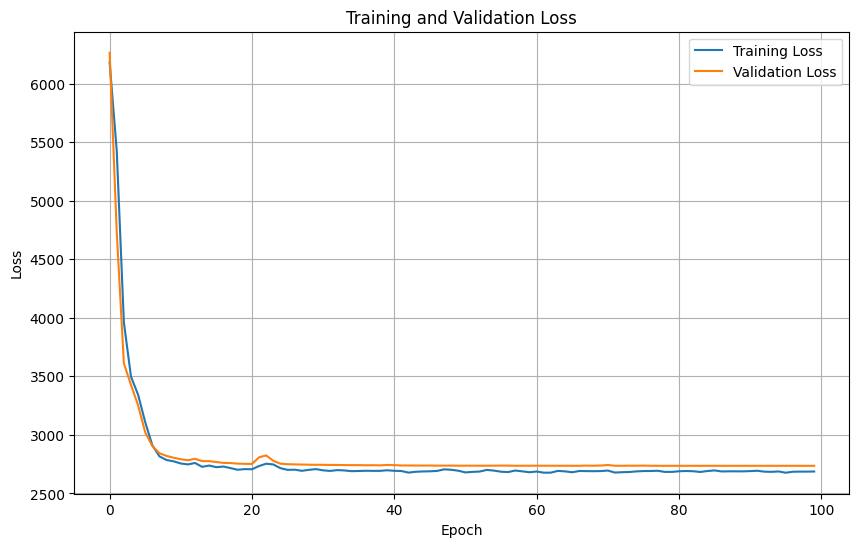

Test Loss: 2646.494324
MSE Loss: 284.702744
Physics Loss: 8157.340942


INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-01-01 00:00:00'], dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.016711 seconds


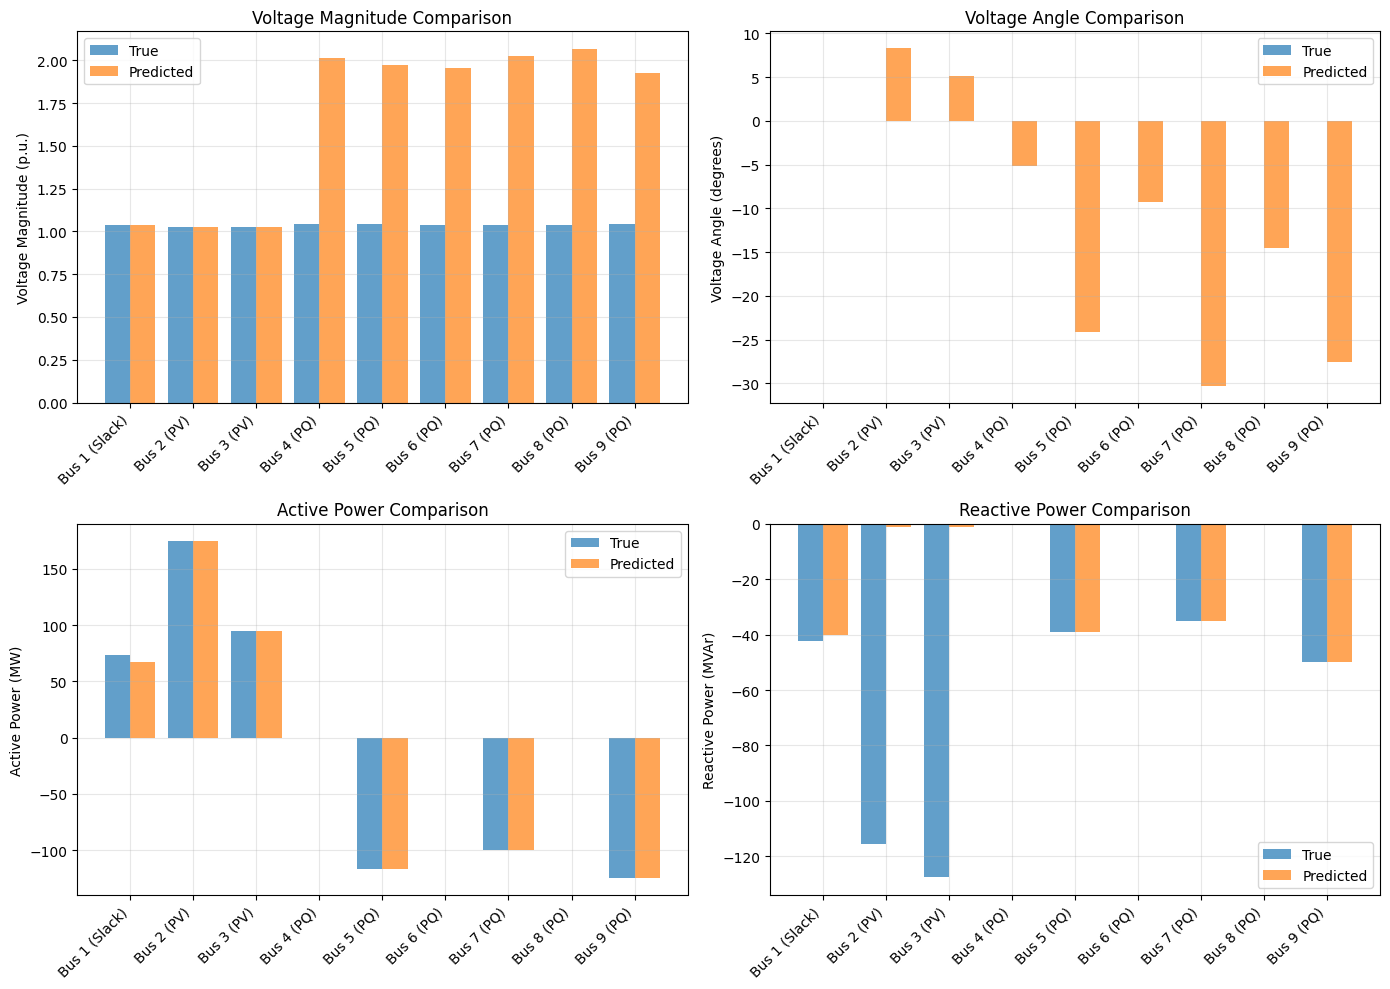

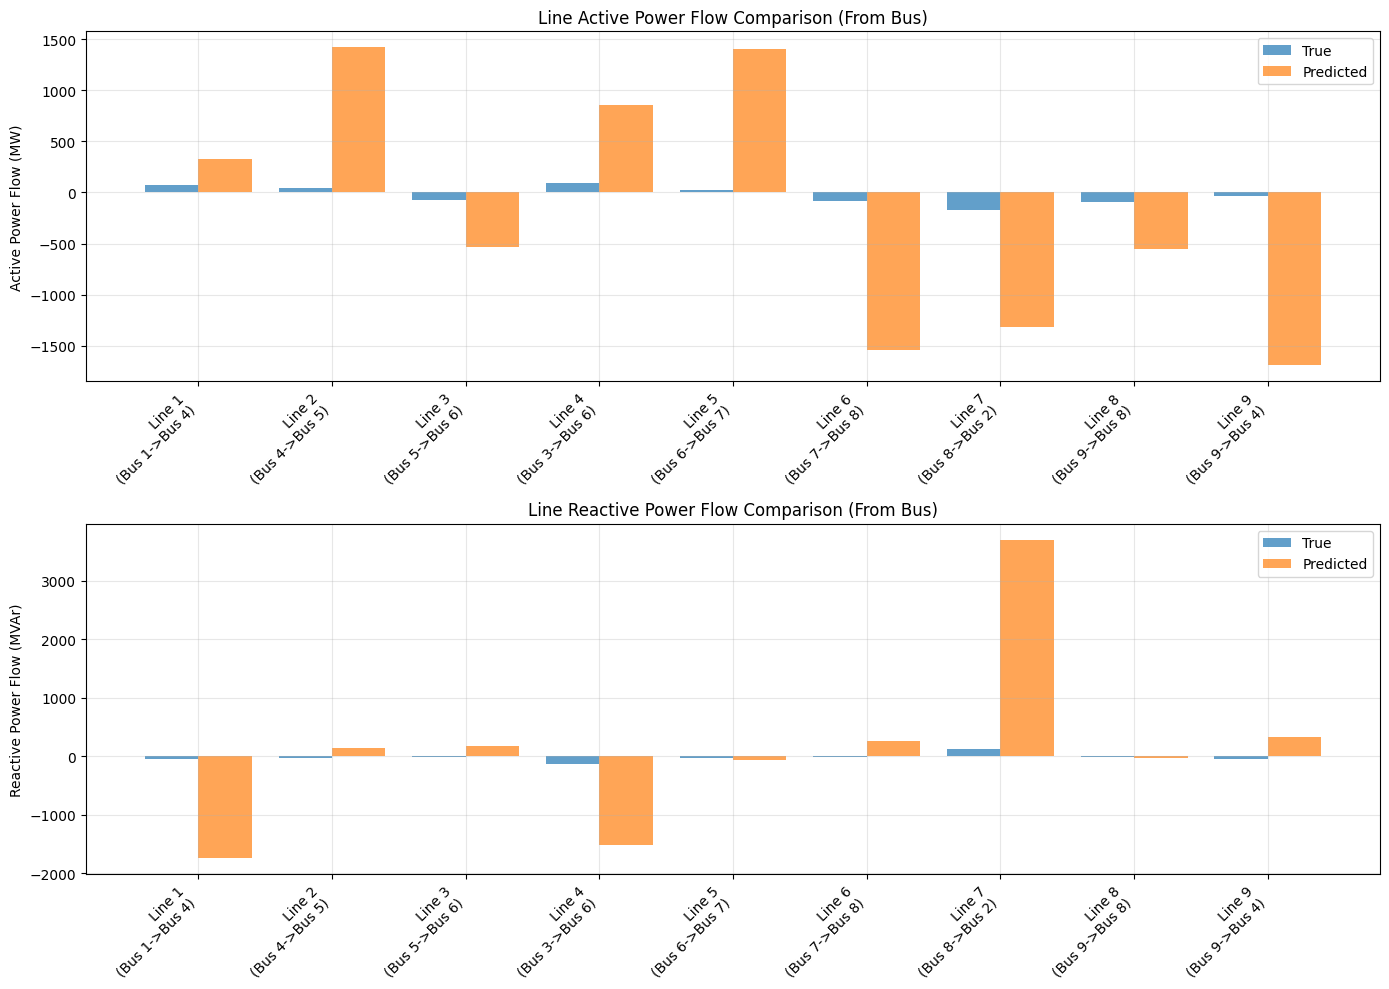

Model Performance Metrics:
Voltage Magnitude MAE: 0.634946 p.u.
Voltage Angle RMSE: 17.242596 degrees
Active Power MAE: 0.689454 MW
Reactive Power MAE: 26.948870 MVAr
Line Active Power Flow MAE: 994.178665 MW
Line Reactive Power Flow MAE: 859.041532 MVAr


INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-01-01 00:00:00'], dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Newton-Raphson solved in 0 iterations with error of 0.000001 in 0.004168 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-01-01 00:00:00'], dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Newton-Raphson solved in 0 iterations with error of 0.000001 in 0.005174 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-01-01 00:00:00'], dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Newton-Raphson solved in 0 iterations with error of 0.000001 in 0.000000 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-01-01 00:00:00'], dtype='datetime64[ns]', name='snapshot', f

GNN Inference Time: 4.51 ± 6.66 ms
Traditional PF Time: 173.76 ± 60.14 ms
Speedup: 38.56x


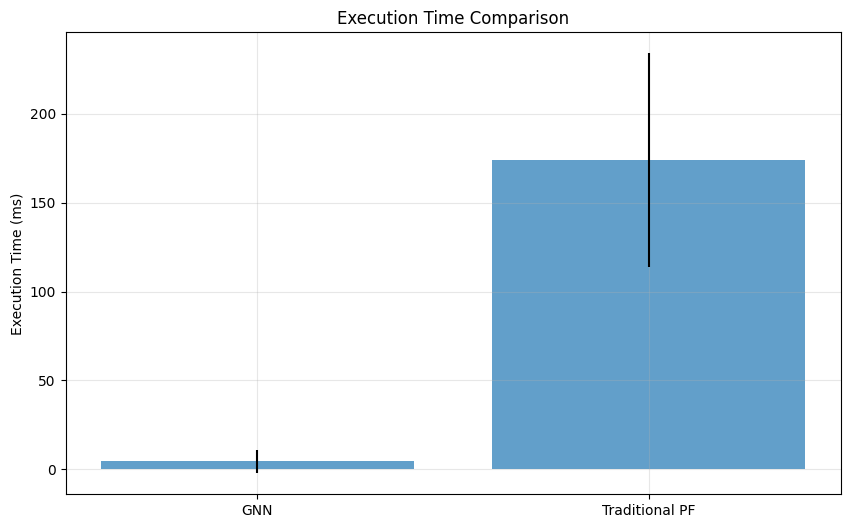

In [44]:
# Generate training data
#networks = generate_training_data(n, num_scenarios=50, steps_per_scenario=15)

# Train the model
model, losses = train_power_flow_gnn(networks, num_epochs=100)

# Create a test network with different parameters
test_network = create_9_bus_network(steps=1, p_set_gen2=175, p_set_gen3=95, plot=False)
test_network.pf(use_seed=True)

# Evaluate the model
results = evaluate_model(model, test_network)

# Visualize results
visualize_results(results, test_network)

# Compare execution time
compare_execution_time(model, test_network)
